In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
file_path = "/content/customer_support_tickets.csv"
df = pd.read_csv(file_path)

In [6]:
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Dataset loaded successfully!
Shape: (8469, 17)
Columns: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']
   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue  

In [8]:
possible_targets = [c for c in df.columns if "satisfaction" in c.lower()]

if possible_targets:
    target = possible_targets[0]
    print(f"\n Detected target column: '{target}'")
else:
    raise ValueError(" No satisfaction-related column found. Please rename your target variable.")


 Detected target column: 'Customer Satisfaction Rating'


In [10]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


In [12]:
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(exclude=np.number).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [14]:
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

/tmp/ipython-input-2619193539.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=df, palette="Blues")


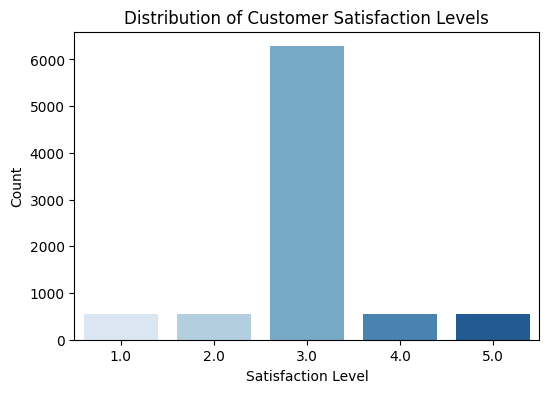

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df, palette="Blues")
plt.title("Distribution of Customer Satisfaction Levels")
plt.xlabel("Satisfaction Level")
plt.ylabel("Count")
plt.show()

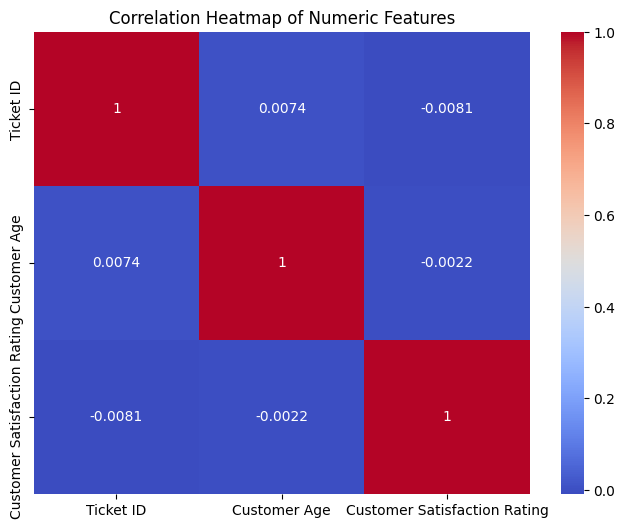

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [20]:
if "Feedback Scores" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target, y="Feedback Scores", data=df, palette="Set2")
    plt.title("Feedback Score vs Satisfaction")
    plt.show()

In [22]:
X = df.drop(columns=[target])
y = df[target]

In [24]:
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("\nNumeric Features:", num_features)
print("Categorical Features:", cat_features)


Numeric Features: ['Ticket ID', 'Customer Age']
Categorical Features: ['Customer Name', 'Customer Email', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    class_weight="balanced"
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [30]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


--- Model Performance ---
Accuracy: 74.14 %

Classification Report:
               precision    recall  f1-score   support

         1.0       0.24      0.38      0.29       111
         2.0       0.17      0.13      0.15       110
         3.0       1.00      0.91      0.95      1256
         4.0       0.19      0.13      0.16       108
         5.0       0.20      0.41      0.27       109

    accuracy                           0.74      1694
   macro avg       0.36      0.39      0.36      1694
weighted avg       0.79      0.74      0.76      1694



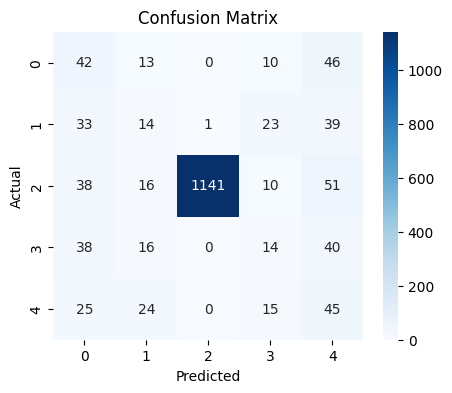

In [32]:
print("\n--- Model Performance ---")
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/tmp/ipython-input-85188026.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


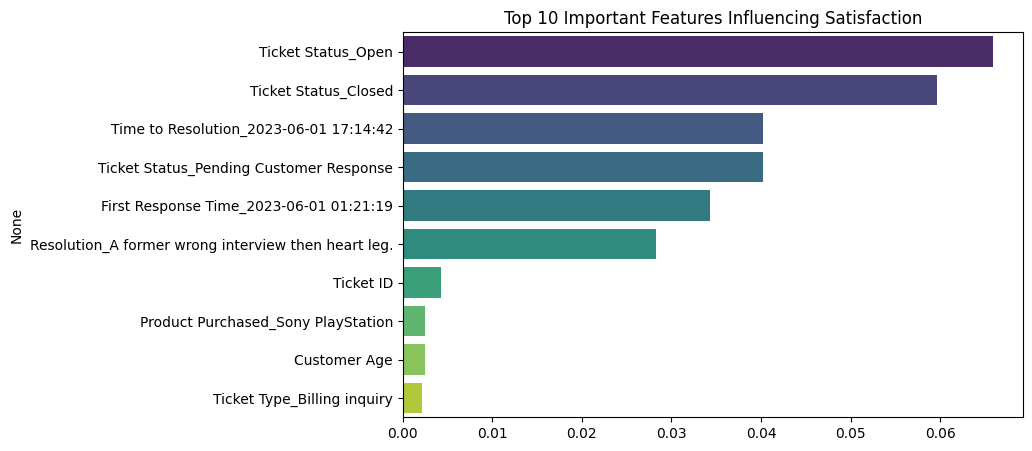

In [34]:
model = pipeline.named_steps["model"]
encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
encoded_features = list(encoder.get_feature_names_out(cat_features))
all_features = num_features + encoded_features

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Top 10 Important Features Influencing Satisfaction")
plt.show()


In [36]:
print("\n--- Example Prediction ---")


--- Example Prediction ---


In [37]:
example = {}

for col in X.columns:
    if col in num_features:
        example[col] = float(df[col].median())
    else:
        example[col] = df[col].mode()[0]

new_df = pd.DataFrame([example])
prediction = pipeline.predict(new_df)[0]
print(f" Predicted Satisfaction Level: {prediction}")

 Predicted Satisfaction Level: 3.0
